# Versuch einer Objektdefinition über Minima

Vielleicht ist es möglich Objekte aus dem IR-10.8-µm-Kanal über die Minima und davon ausgehenden Grenzen zu definieren.

Um das zu untersuchen, brauchen wir zunächst ein paar Pakete.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

import cv2 

import datetime as dt

import l15_msevi.msevi as msv

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking")
import tracking_common as tc

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Beispieldaten laden

Wir laden für den 28.07.2012, 12:00 UTC ein Beispiel.

In [2]:
t = dt.datetime(2012,7,28,12,0)

s = msv.MSevi(time=t,chan_list=["IR_108"])
s.lonlat()
s.rad2bt()

ir108 = s.bt['IR_108']

Region suggests use of hdf file


Nun suchen wir nach den lokalen Minima im Bild.

In [18]:
minima = peak_local_max(-ir108, min_distance=2,threshold_abs=-273)

In [9]:
print minima

[[597  88]
 [596  57]
 [596  45]
 ...
 [  2 450]
 [  2 398]
 [  2 255]]


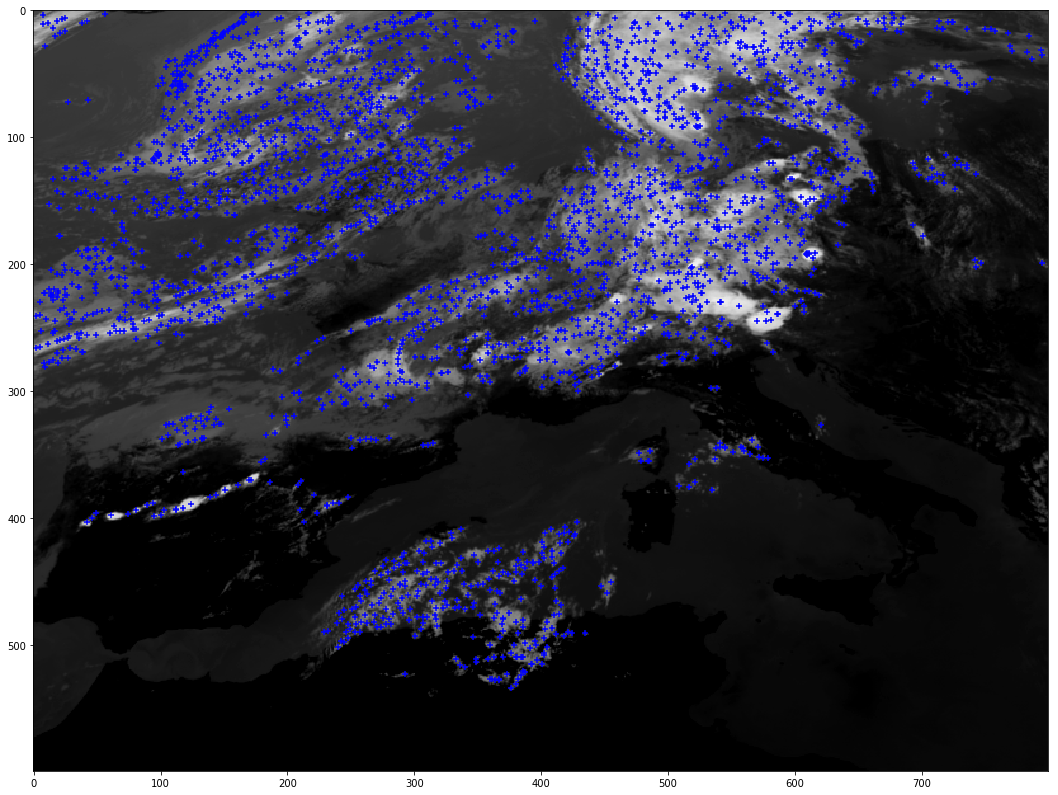

In [19]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')

x = [m[1] for m in minima]
y = [m[0] for m in minima]

ax.scatter(x,y,marker='+',color='blue')

Das sind ziemlich viele Minima. Es gibt mehrere Möglichkeiten deren Anzahl zu reduzieren:

1. das Eingangsbild glätten und maskieren
2. den Mindestabstand vergrößeren
3. den Schwellwert strenger wählen.

Das probieren wir im Folgenden mal aus.

## Glättung und Maskierung des Eingangsbildes

Für die Glättung gibt es mehrere Möglichkeiten. Hier probieren wir Folgende aus:

1. Mittelwertglättung
2. Gauß'scher Filter
3. Medianglättung
4. bilateraler Filter

All diese Verfahren sind abhängig von der Filterbreite. Was ist ein guter Wert dafür?

In [4]:
ir108_transformed = (tc.scale_array_min_max(ir108)*255).astype("uint8")

mean_blur = cv2.blur(ir108_transformed,(5,5))
gauss_blur = cv2.GaussianBlur(ir108_transformed,(5,5),0)
median_blur = cv2.medianBlur(ir108_transformed,5)
bilateral_blur = cv2.bilateralFilter(ir108_transformed,15,15,15) 

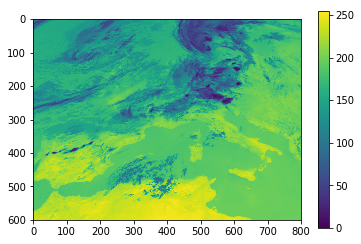

In [49]:
plt.imshow(ir108_transformed)
plt.colorbar()

### Darstellung der Glättungsergebnisse

Text(0.5,1,u'bilateraler Filter')

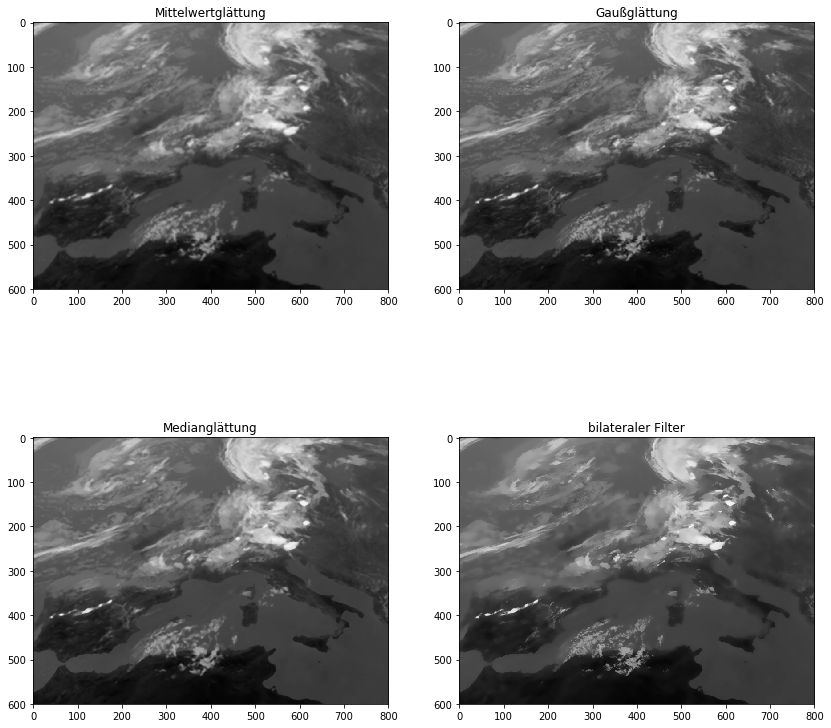

In [53]:
fig,ax = plt.subplots(2,2,figsize=(14,14))
ax[0,0].imshow(mean_blur,vmin=0,vmax=255,cmap='gray_r')
ax[0,0].set_title(u"Mittelwertglättung")
ax[0,1].imshow(gauss_blur,vmin=0,vmax=255,cmap='gray_r')
ax[0,1].set_title(u"Gaußglättung")
ax[1,0].imshow(median_blur,vmin=0,vmax=255,cmap='gray_r')
ax[1,0].set_title(u"Medianglättung")
ax[1,1].imshow(bilateral_blur,vmin=0,vmax=255,cmap='gray_r')
ax[1,1].set_title(u"bilateraler Filter")

Die Glättung mit dem bilateralen Filter sieht subjektiv am besten aus. Das Feld ist relativ stark geglättet, aber die Kanten sind noch gut erhalten.

In [115]:
thresh = (273 - np.min(ir108)) / (np.max(ir108) - np.min(ir108))*255

In [116]:
thresh

140.29909227709862

In [117]:
minima = peak_local_max(-bilateral_blur, min_distance=2,threshold_abs=thresh)

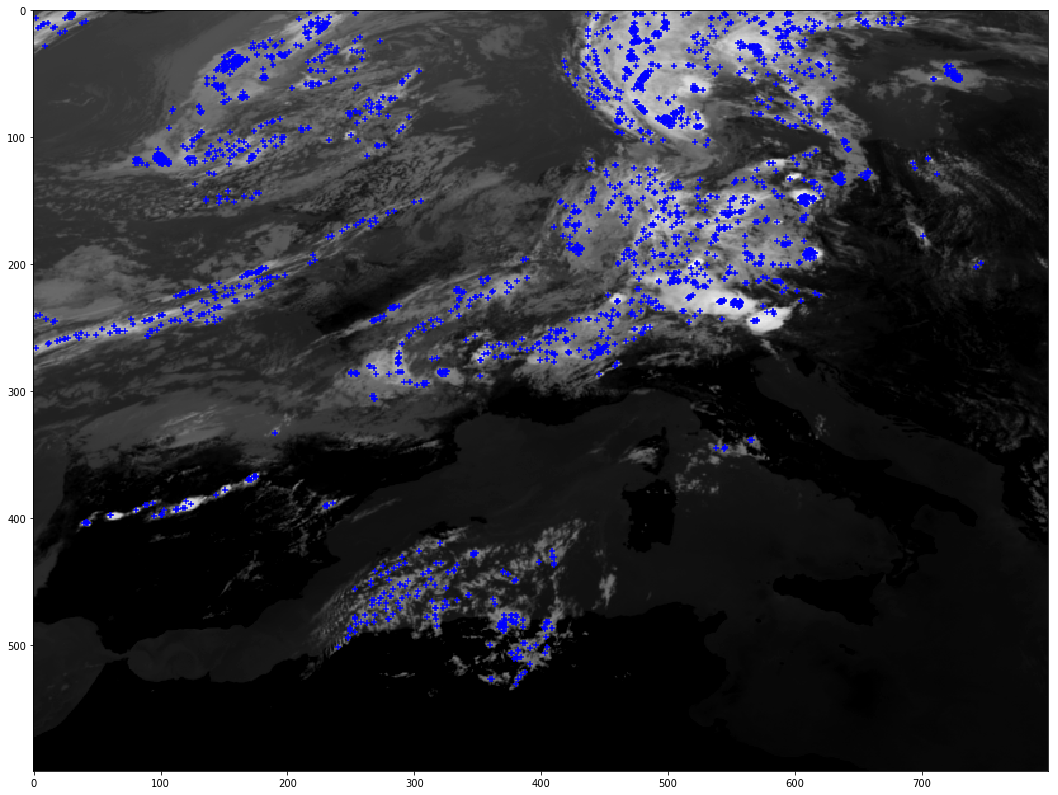

In [118]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')

x = [m[1] for m in minima]
y = [m[0] for m in minima]

ax.scatter(x,y,marker='+',color='blue')

Das sieht schon besser aus. Nur die Häufungen von Minima sind seltsam.

## Vergrößerung des Mindestabstandes

In [111]:
minima = peak_local_max(-ir108, min_distance=5,threshold_abs=-273)

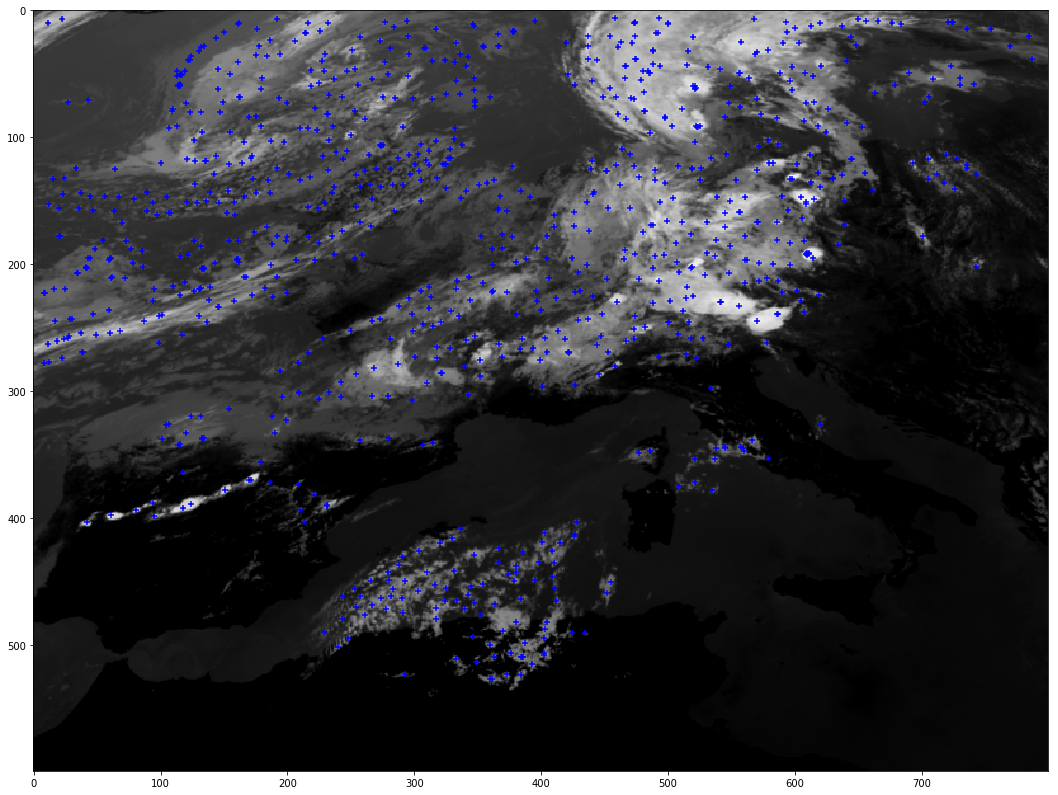

In [112]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')

x = [m[1] for m in minima]
y = [m[0] for m in minima]

ax.scatter(x,y,marker='+',color='blue')

Das sieht besser aus.

## Strengere Schwellwerte

In [113]:
minima = peak_local_max(-ir108, min_distance=2,threshold_abs=-250)

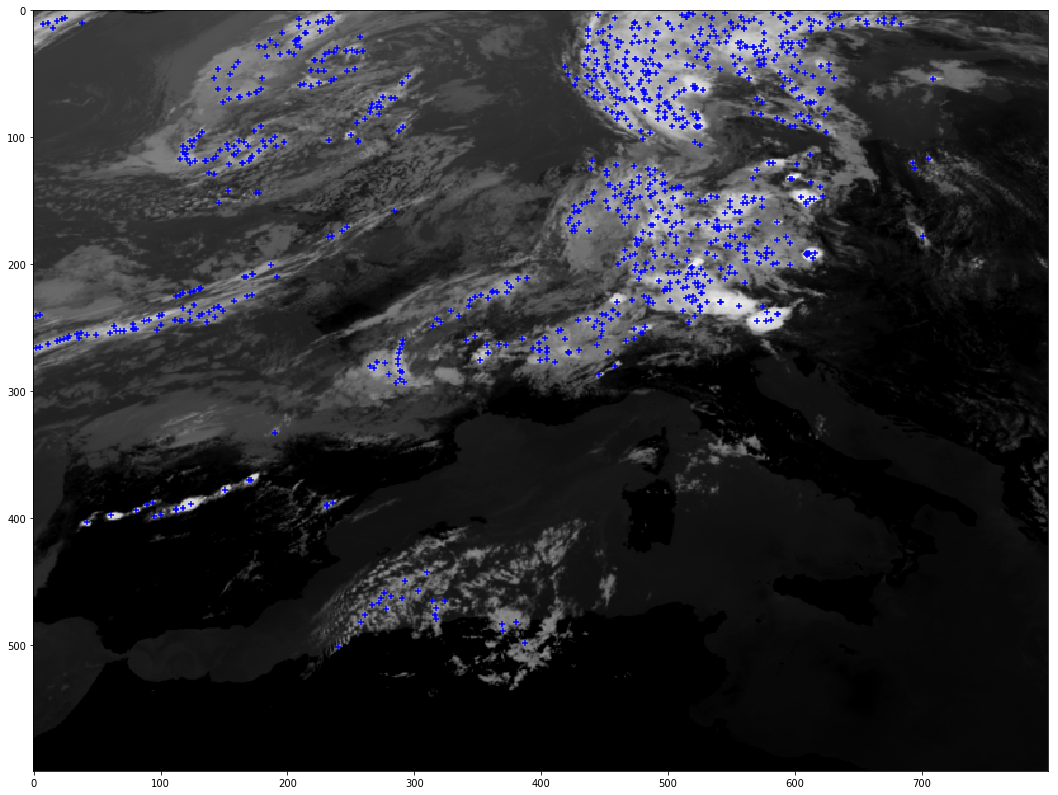

In [114]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')

x = [m[1] for m in minima]
y = [m[0] for m in minima]

ax.scatter(x,y,marker='+',color='blue')

Das sind immernoch viele Minima, aber sinnvoller verteilt.

## Kombination aus allem

In [5]:
th = 250

thresh = (th - np.min(ir108)) / (np.max(ir108) - np.min(ir108))*255

test = 255 - bilateral_blur
thr = 255 - thresh

minima = peak_local_max(test, min_distance=15,threshold_abs=thr)

#from skimage.morphology import extrema
#minima = extrema.h_minima(bilateral_blur,30)

In [6]:
minima

array([[471, 317],
       [471, 316],
       [404,  43],
       [404,  42],
       [404,  41],
       [404,  40],
       [403,  42],
       [403,  41],
       [398,  61],
       [398,  60],
       [392, 119],
       [392, 118],
       [391, 231],
       [391, 230],
       [390, 231],
       [389, 124],
       [378, 151],
       [370, 171],
       [370, 170],
       [370, 169],
       [369, 170],
       [287, 446],
       [280, 265],
       [280, 264],
       [279, 287],
       [278, 288],
       [278, 287],
       [277, 287],
       [276, 399],
       [276, 353],
       [276, 352],
       [275, 287],
       [274, 288],
       [274, 287],
       [273, 288],
       [270, 422],
       [269, 422],
       [269, 421],
       [259, 385],
       [259,  25],
       [259,  24],
       [258,  27],
       [254,  60],
       [251, 474],
       [251, 473],
       [245, 570],
       [245, 569],
       [245, 568],
       [245, 567],
       [244, 570],
       [243, 438],
       [243, 437],
       [241,

In [7]:
test = 255 - bilateral_blur

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colourbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

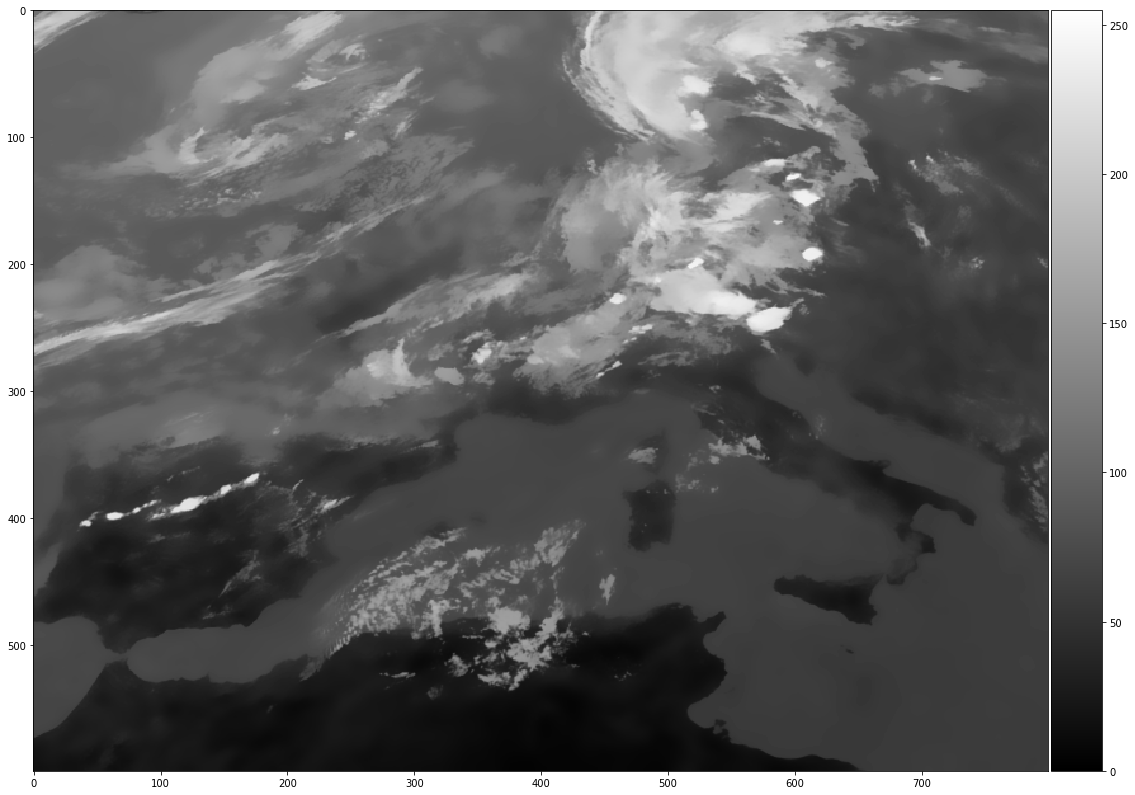

In [13]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
#ax.imshow(np.ma.masked_less(minima,1))
test_plot = ax.imshow(test,vmin=0,vmax=255,cmap='gray')
colourbar(test_plot)

In [9]:
print(np.max(ir108) - np.min(ir108))
print(th - np.min(ir108))  
print thresh

109.76179048091547
37.39011596541775
86.86519716384645


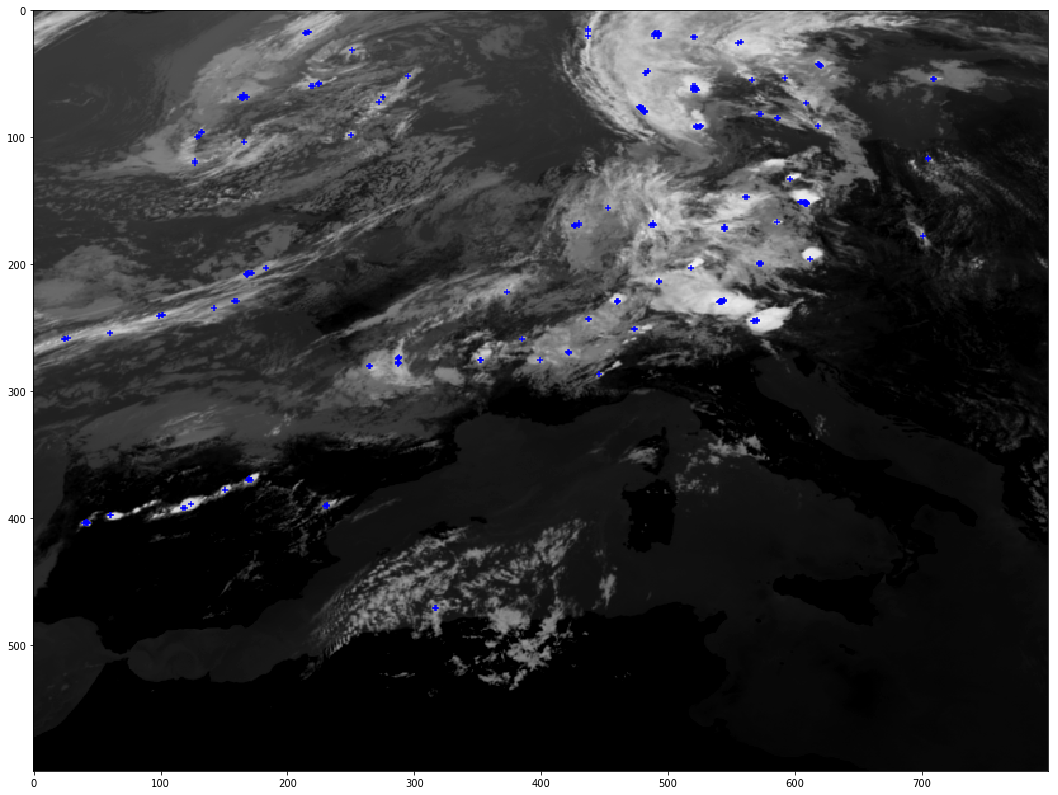

In [14]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')

x = [m[1] for m in minima]
y = [m[0] for m in minima]

ax.scatter(x,y,marker='+',color='blue')

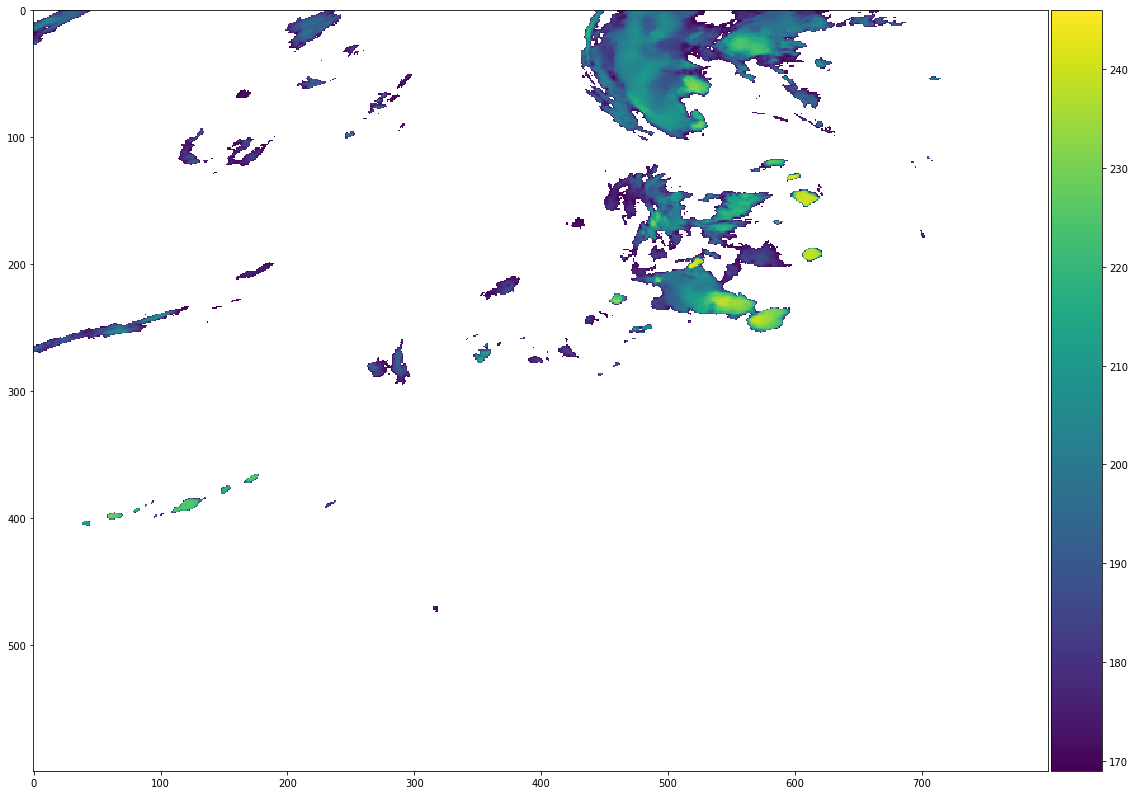

In [15]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
test_plot = ax.imshow(np.ma.masked_less(test,thr))
colourbar(test_plot)

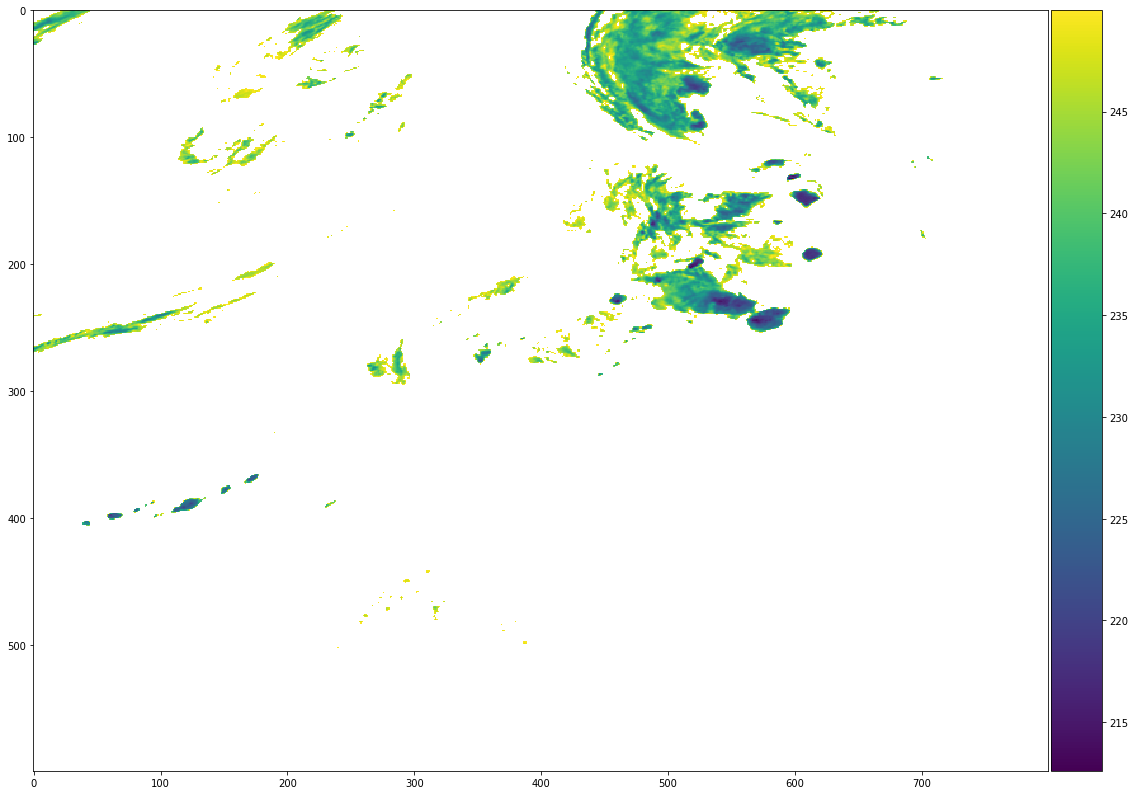

In [190]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
test_plot = ax.imshow(np.ma.masked_greater(ir108,250))
colourbar(test_plot)

Das sieht schon recht gut aus. Bloß dies Häufung von Minima ist seltsam. Das kann man wahrschenlich folgendermaßen beseitigen:

1. Matrix mit Nullen erzeugen
2. Punkte die ein Minimum haben auf 1 setzen
3. diese Matrix markieren
4. Massenschwerpunkte der verschiedenen Objekte bestimmen und als neue Minima betrachten

In [16]:
from scipy import ndimage as ndi

new_minima = np.zeros_like(ir108)

for m in minima:
    new_minima[m[0],m[1]] = 1
    
lab,nlab = ndi.measurements.label(new_minima)

new_mins = ndi.center_of_mass(new_minima,lab,np.arange(1,nlab))

In [17]:
new_mins

[(15.5, 437.0),
 (17.0, 216.5),
 (18.0, 214.5),
 (18.90909090909091, 491.27272727272725),
 (20.0, 437.0),
 (21.0, 520.5),
 (25.0, 558.0),
 (26.0, 555.0),
 (31.0, 251.0),
 (42.5, 619.0),
 (44.0, 621.0),
 (48.0, 484.0),
 (49.0, 482.5),
 (52.0, 295.0),
 (53.0, 592.0),
 (54.0, 709.5),
 (55.0, 566.0),
 (57.666666666666664, 224.66666666666666),
 (60.0, 219.5),
 (61.75, 521.0833333333334),
 (68.0, 164.75),
 (68.0, 168.0),
 (68.0, 275.0),
 (72.0, 272.0),
 (73.0, 609.0),
 (77.84615384615384, 479.6923076923077),
 (82.0, 572.5),
 (85.0, 586.5),
 (91.57142857142857, 523.8571428571429),
 (91.0, 618.0),
 (96.0, 132.5),
 (98.0, 250.0),
 (99.0, 130.0),
 (100.0, 129.0),
 (104.0, 166.0),
 (116.5, 705.0),
 (119.5, 127.0),
 (133.0, 596.0),
 (147.0, 561.5),
 (151.76923076923077, 607.6923076923077),
 (156.0, 453.0),
 (167.0, 586.0),
 (168.5, 430.0),
 (168.75, 488.0),
 (169.5, 426.5),
 (171.5, 544.5),
 (178.0, 701.0),
 (196.0, 612.0),
 (199.5, 572.5),
 (203.0, 183.0),
 (203.0, 518.0),
 (207.625, 169.25),
 (2

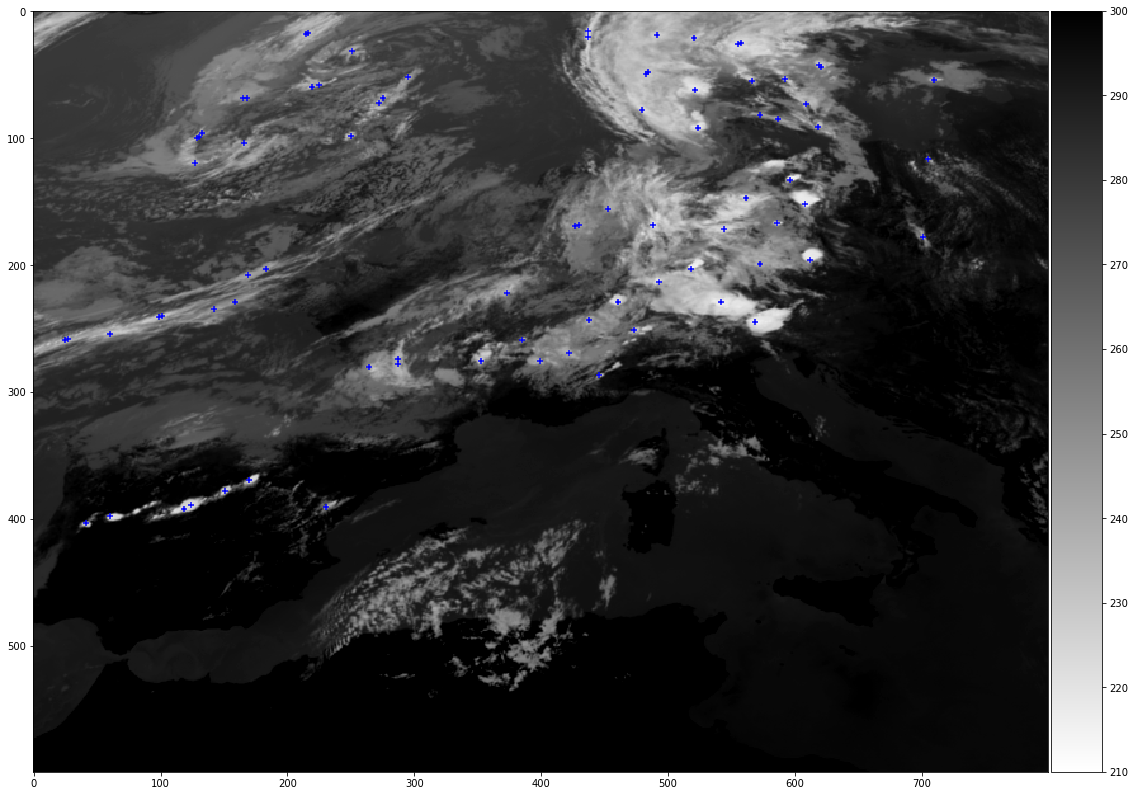

In [19]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ir_plot = ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')
colourbar(ir_plot)

x = [m[1] for m in new_mins]
y = [m[0] for m in new_mins]

ax.scatter(x,y,marker='+',color='blue')

Das sieht als repräsentativer für die Objekte aund Startpunkte für die Objektdefinition ziemlich gut aus. Es sind Minima von nichtkonvektiven Wolken dabei, aber um diese zu entfernen, ist wahrscheinlich eine Wolkentypisierung nötig.

In [27]:
ct = msv.MSGtools.get_nwcsaf_prod('CT',t,calibrate=True)

In [28]:
ct = np.ma.masked_where(np.logical_or(ct<5, ct>10),ct)

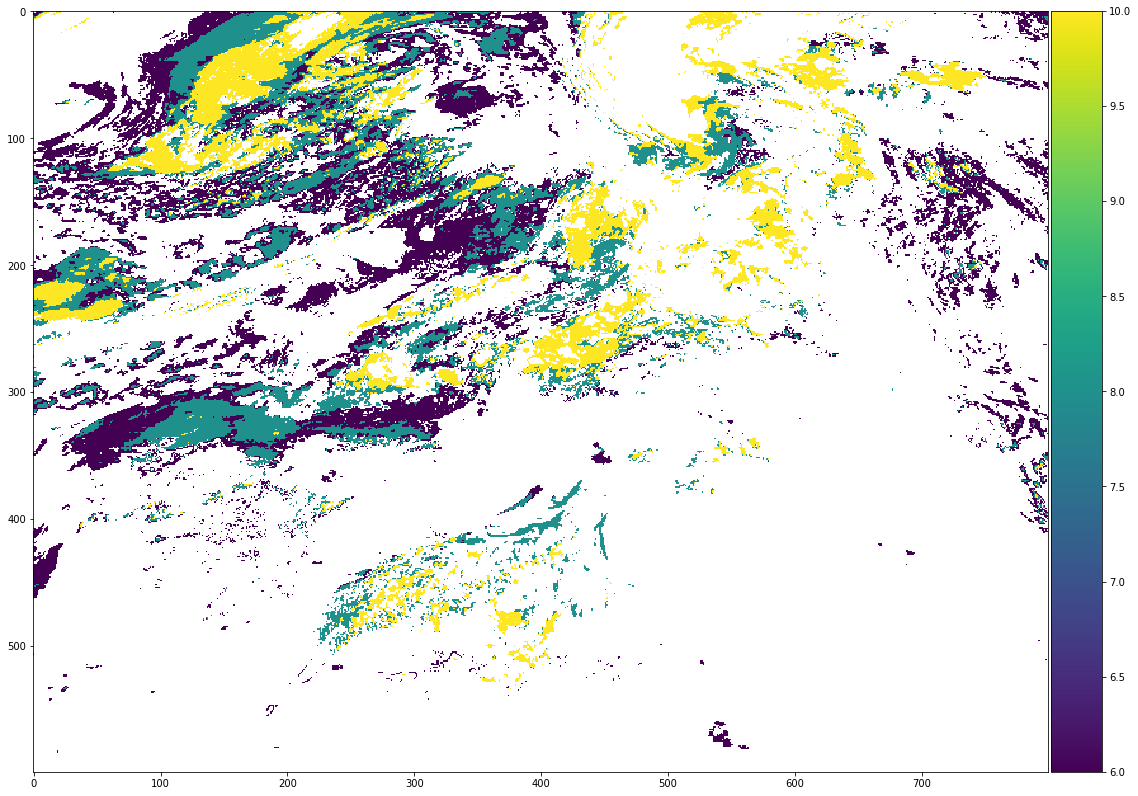

In [29]:
h = 14
fig,ax = plt.subplots(1,1,figsize=(h*1.61803,h))
ct_plot = ax.imshow(ct)
colourbar(ct_plot)